In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torchviz import make_dot

# Loading, scaling the data
data has been explored and concaternated in `data_preparerationipynb`

In [70]:
# Load the dataset
df = pd.read_csv('../data/train.csv')
df.shape

(2000, 21)

In [71]:
# Separate the target variable from the features
y = df['price_range'].values
X = df.drop('price_range', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

#  Split the data into train, validation, and test sets 0.7, 0.15, 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(1400, 20) (300, 20) (300, 20)
(1400,) (300,) (300,)


# Dataset

In [72]:
from sklearn.preprocessing import OneHotEncoder

class PhoneDataset(Dataset):
    def __init__(self, X, y):
        # Convert inputs to torch 32 bit float tensor
        X = torch.tensor(X, dtype=torch.float32)
        # One hot encode the labels
        self.enc = OneHotEncoder(sparse=False)
        y = self.enc.fit_transform(y.reshape(-1, 1))
        y = torch.tensor(y, dtype=torch.float32)
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} is out of range")

        return self.X[idx], self.y[idx]

Forward feed neural network


In [73]:
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(in_features=20, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=4)

        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Loss function

In [74]:
# how to evaluate model with wandb
def train(args, model, train_loader, optimizer, criterion):
    # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.train()
    train_loss = 0
    correct_train = 0

    # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Feed the inputs to the network
        outputs = model(inputs)

        output_category_train = np.argmax(outputs.detach().numpy(), axis=1)
        target_category_train = np.argmax(targets.detach().numpy(), axis=1)
        # Compute the loss
        loss = criterion(outputs, targets)

        # Backpropagate the gradient
        loss.backward()

        # Update the weights
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (output_category_train == target_category_train).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy_train = 100. * correct_train / len(train_loader.dataset)
    wandb.log({'train_loss': train_loss, 'train_accuracy': accuracy_train})


In [75]:
def test(args, model, criterion, test_loader):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            # Load the input features and labels from the test dataset

            output = model(data)
            output_category = np.argmax(output, axis=1)
            target_category = np.argmax(target, axis=1)
            # Compute the loss sum up batch loss
            test_loss += criterion(output, target).item()


            _, predicted = torch.max(output.data, 1)
            correct += (output_category == target_category).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        wandb.log({'test_loss': test_loss, 'test_accuracy': accuracy})

# Config

In [76]:
wandb.init(project="phone-price-prediction")

# Data loader

config = wandb.config  # Initialize config

config.batch_size = 32          # input batch size for training (default: 64)
config.test_batch_size = 64    # input batch size for testing (default: 1000)
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 0.001               # learning rate (default: 0.01)
config.momentum = 0.1           # SGD momentum (default: 0.5)
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-08
config.rho = 0.9
# config.no_cuda = True         # disables CUDA training
config.seed = 42               # random seed (default: 42)
config.log_interval = 10

# Create the data loaders
train_dataset = PhoneDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

val_dataset = PhoneDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=config.test_batch_size, shuffle=True)

test_dataset = PhoneDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, shuffle=True)

device  = torch.device("cpu")
kwargs = {}

torch.manual_seed(config.seed)

model = FFNN().to(device)

loss = nn.MSELoss()

#optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum)
#optimizer = optim.RMSprop(model.parameters(), lr=config.lr, eps=config.epsilon, alpha=config.rho, momentum=config.momentum)
optimizer = optim.Adam(model.parameters(), lr=config.lr, betas=(config.beta1, config.beta2), eps=config.epsilon)

# wandb.watch(model, log="all")

for epoch in range(1, config.epochs + 1):
    train(config, model, train_loader, optimizer, loss)
    test(config, model, loss , val_loader)

wandb.finish()

/Users/adam/mambaforge/envs/ns_a1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/adam/mambaforge/envs/ns_a1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/adam/mambaforge/envs/ns_a1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


test_accuracy,▁▁▂▃▅▆▇▇▇▇██████████████████████████████
test_loss,██▇▇▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▂▄▅▆▇▇▇██████████████████████████████
train_loss,███▇▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,92.33333
test_loss,0.00043
train_accuracy,99.57143
train_loss,0.00016


## NN Architecture

/Users/adam/mambaforge/envs/ns_a1/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


torch.Size([64, 20]) torch.Size([64, 4])


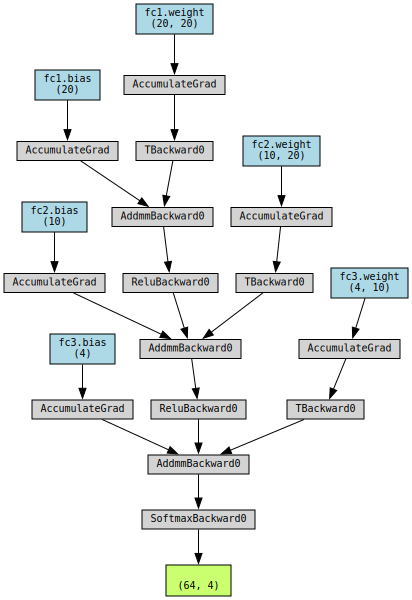

In [18]:
train_dataset = PhoneDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Get one batch of training data
X, y = next(iter(train_loader))
print(X.shape, y.shape)
model = FFNN()
y = model(X)

y = model(X)
make_dot(y, params=dict(model.named_parameters()))